## Helper Functions

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# loads an image into a numpy array and scales it to 255 if necessary
def load_img(file):
    image = mpimg.imread(file)
    if file[-4:] == '.png':
        image = np.uint8(image * 255)
    #if file[-4:] == '.jpg':
    #    image = image.astype(np.float32)/255
    return image

# plots an array of images into an image matrix
def plot_image_array(images, titles = [], ncols = 2, nrows = -1, fig_width = 20, fig_row_height = 4.5):
    if nrows <= 0:
        nrows = math.ceil(len(images) / 2)
    fig = plt.figure(figsize=(fig_width, nrows * fig_row_height))
    for idx, img in enumerate(images):
        if idx >= (nrows * ncols):
            break
        a=fig.add_subplot(nrows, ncols, idx + 1)
        if len(img.shape) == 2:
            imgplot = plt.imshow(img, cmap = 'gray' if len(img.shape) == 2 else None)
        else:
            imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))     
            imgplot = plt.imshow(img)
        if(len(titles) >= idx):
            a.set_title(titles[idx])
    fig.tight_layout()
            
# saves an array of images to a folder         
def save_images(folder, images, names):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for img, fname in zip(images, names):
        fname = fname.replace('/', '_')
        fname = fname.replace(' ', '_')
        fname = fname.replace(':', '_')
        fname = fname.replace('.jpg', '')
        p = os.path.join(folder, os.path.split(fname)[-1])

        p += '.jpg'
        if np.max(img) == 1:
            img = img * 255
        #print('saving', p)
        cv2.imwrite(p, img)

## Import Training Data

In [31]:
import glob
import matplotlib.image as mpimg
import os

loc_vehicles = './training_data/vehicles'
loc_non_vehicles = './training_data/non-vehicles'

# reurns a dictionary with an entry for each subfolder of folder 
# and a list with all image files for each category
def load_training_dictionary(folder):
    result = {}
    num_samples = 0
    categories = [dI for dI in os.listdir(folder) if os.path.isdir(os.path.join(folder, dI))]
    for c in categories:
        image_files = glob.glob(os.path.normpath(os.path.join(folder, c, '*.png')))
        num_samples += len(image_files)
        result[c] = image_files
        print(len(image_files), 'samples loaded for category', c)
        
    print(num_samples, 'samples loaded from', folder, '\n')
    return result, num_samples

def create_grouped_label_data(sample_dicts, group_size=12, label_size=None):
    samples = []
    labels = []
    categories = []
    groups = []
    
    group = 0
    for label in range(2):
        cat_id = label * 10
        
        cat_size = None
        if label_size:
            cat_size = np.int32(label_size / len(sample_dicts[label].keys()))
            
        for category in sample_dicts[label]:
            d = sample_dicts[label][category][:cat_size]
            samples += d
            labels += list(np.repeat(label, len(d)))
            categories += list(np.repeat(cat_id, len(d)))
            n_groups = len(d) // group_size
            n_remaining = len(d) % group_size
            groups += list(np.repeat(np.arange(group, group + n_groups), group_size))
            group += n_groups
            
            if n_remaining > 0:
                groups += list(np.repeat(group + n_groups, n_remaining))
                group += 1

            cat_id += 1
    return {'samples': samples, 
            'labels': np.array(labels), 
            'categories': np.array(categories), 
            'groups': np.array(groups)}
            
            
dict_vehicles, num_vehicles = load_training_dictionary(loc_vehicles)
dict_non_vehicles, num_non_vehicles = load_training_dictionary(loc_non_vehicles)

data = create_grouped_label_data((dict_vehicles, dict_non_vehicles))
print(len(data['samples']), 'total samples loaded')

834 samples loaded for category GTI_Far
909 samples loaded for category GTI_Left
419 samples loaded for category GTI_MiddleClose
664 samples loaded for category GTI_Right
5966 samples loaded for category KITTI_extracted
176 samples loaded for category Udacity
8968 samples loaded from ./training_data/vehicles 

5068 samples loaded for category Extras
3900 samples loaded for category GTI
8968 samples loaded from ./training_data/non-vehicles 

17936 total samples loaded


In [ ]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC

# Convert color
def convert_color(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            print('color space not recognized')
            feature_image = np.copy(image) 
    else: 
        feature_image = np.copy(image)   
    return feature_image

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, hog_channels=[0, 1, 2], feature_vec=True):
    hog_features = []
    for channel in hog_channels:
        hog_features.append(hog(img[:,:,channel], orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2',
                                  transform_sqrt=True, 
                                  visualise=False, feature_vector=False))
        
    if feature_vec:
        return np.ravel(hog_features)
    else:
        return hog_features

# Define a function to compute binned color features  
def bin_spatial(img, size=32):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, (size, size)).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(image, color_space='RGB', spatial_size=32,
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2,
                        hog_channels=[0, 1, 2],
                        hog_features=None,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images

    # apply color conversion if other than 'RGB'
    feature_image = convert_color(image, color_space=color_space)

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        features.append(hist_features)
    if hog_feat == True:
        if hog_features is None:
            hog_features = get_hog_features(feature_image, orient, pix_per_cell, cell_per_block, hog_channels, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(hog_features)
                          
    # Return list of feature vectors
    return np.concatenate(features)
    
def create_feature_list(data):
    features = []                  
    for file in data['samples']:
        file_features = []
        # Read in each one by one
        image = load_img(file)
        features.append(extract_features(image, **data['params']))
        
    # Create an array stack of feature vectors
    X = np.vstack(features).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    data['features'] = scaled_X
    data['scaler'] = X_scaler


#### LOAD TRAINING FEATURES ####
data['params'] = {'color_space': 'LUV',
                  'spatial_size': 32, 
                  'hist_bins': 32, 
                  'orient': 9, 
                  'pix_per_cell': 8, 
                  'cell_per_block': 2, 
                  'hog_channels': [0, 1, 2],
                  'spatial_feat': True,
                  'hist_feat': True,
                  'hog_feat': True}

create_feature_list(data)

#### TESTING ####
print('removing unimportant features')

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

print(data['features'].shape)
clf = ExtraTreesClassifier()
clf = clf.fit(data['features'], data['labels'])
#clf.feature_importances_  

data['reduction'] = SelectFromModel(clf, prefit=True)

#data['features'] = data['reduction'].transform(data['features'])
print(data['features'] .shape)               

print('Training SVM using cross validation')
data['svc'] = svm.SVC(kernel='linear', C=1)
cv = GroupKFold(n_splits=3)
score = cross_val_score(data['svc'], data['features'], data['labels'], groups=data['groups'], scoring='f1_macro', cv=cv)
print("Accuracy: {:0.3f} (+/- {:0.4f})".format(score.mean(), score.std() * 2))
data['svc'].fit(data['features'], data['labels'])

from sklearn.metrics import accuracy_score
pred = data['svc'].predict(data['features'])
accuracy_score(data['labels'], pred, normalize=True)

removing unimportant features
(17936, 8460)
(17936, 8460)
Training SVM using cross validation


In [ ]:
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=2)

for train_index, test_index in group_kfold.split(data['features'], data['labels'], data['groups']):
    X_train, X_test = data['features'][train_index], data['features'][test_index]
    y_train, y_test = data['labels'][train_index], data['labels'][test_index]
    c_train, c_test = data['categories'][train_index], data['categories'][test_index]
    g_train, g_test = data['groups'][train_index], data['groups'][test_index]
      
    # print sizes of train and test
    print('Number of samples for train and test:', len(y_train), len(y_test), '\n')        
        
    # check if vehicles and non vehicles are roughly 0.5 for train and test
    hy_train = np.histogram(y_train, bins=[-0.5, 0.5, 1.5], density=True)
    hy_test = np.histogram(y_test, bins=[-0.5, 0.5, 1.5], density=True)
    print('Distribution vehicles/non-vehicles (train, test):\n', 
          hy_train[0], '\n', 
          hy_test[0], '\n')
    
    # check if categories are equally distributed over train and test
    c_bins = [ v - 0.5 for v in sorted(list(set(c_train).union(set(c_test))))]
    c_bins.append(c_bins[-1] + 1)
    hc_train = np.histogram(c_train, bins=c_bins, density=True)
    hc_test = np.histogram(c_test, bins=c_bins, density=True)
    print('Distribution sub-categories (train, test):\n', 
          hc_train[0], '\n', 
          hc_test[0], '\n')
    
    #check if groups aren't split over train and test
    sg_train = set(g_train)
    sg_test = set(g_test)
    print('Shared groups between train and test:', 
          sg_train.intersection(sg_test), 
          '\n----------------------------------------------\n')
    

In [31]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import svm



color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

for c in color_spaces:
    clf = svm.SVC(kernel='linear', C=1)
    cv = GroupKFold(n_splits=2)
    create_feature_list(data, color_space=c, spatial_size=32,
                                        hist_bins=32, orient=9, 
                                        pix_per_cell=8, cell_per_block=2, hog_channels=[0, 1, 2],
                                        spatial_feat=False, hist_feat=False, hog_feat=True)
    score = cross_val_score(clf, data['features'], data['labels'], groups=data['groups'], cv=cv)
    print("Accuracy for {}: {:0.3f} (+/- {:0.4f})".format(c, score.mean(), score.std() * 2))

Accuracy for RGB: 0.956 (+/- 0.0051)
Accuracy for HSV: 0.971 (+/- 0.0076)
Accuracy for LUV: 0.976 (+/- 0.0113)
Accuracy for HLS: 0.976 (+/- 0.0038)
Accuracy for YUV: 0.976 (+/- 0.0113)
Accuracy for YCrCb: 0.975 (+/- 0.0051)


In [32]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC


# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

tuned_parameters = {'kernel': ['linear'], 'C': [1, 10, 100]}
print("# Tuning hyper-parameters for f1")
print()

clf = GridSearchCV(SVC(), tuned_parameters, cv=cv,
                   scoring='f1')
clf.fit(data['features'], data['labels'], groups=data['groups'])

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

#print("Detailed classification report:")
#print()
#print("The model is trained on the full development set.")
#print("The scores are computed on the full evaluation set.")
#print()
#y_pred = clf.predict(data['features'])
#print(classification_report(data['labels'], y_pred))
#print()


# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.975 (+/-0.004) for {'C': 1, 'kernel': 'linear'}
0.975 (+/-0.004) for {'C': 10, 'kernel': 'linear'}
0.975 (+/-0.004) for {'C': 100, 'kernel': 'linear'}



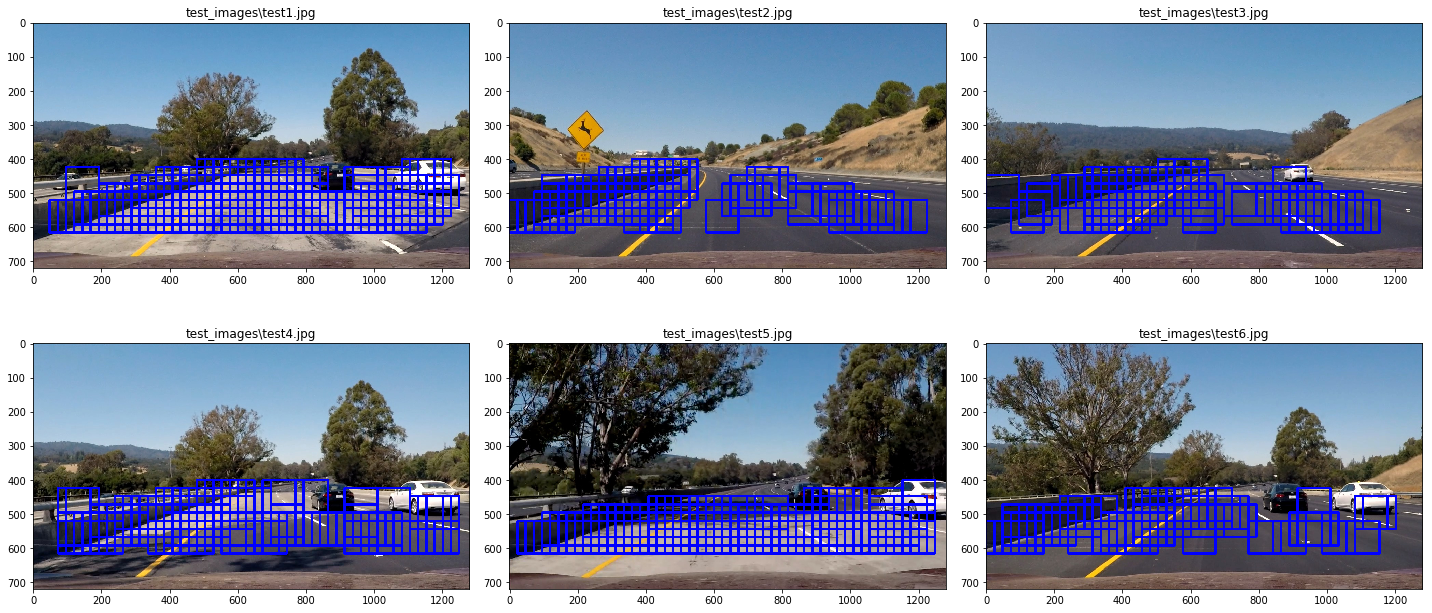

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, feature_params):
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, feature_params['color_space'])
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    #ch1 = ctrans_tosearch[:,:,0]
    #ch2 = ctrans_tosearch[:,:,1]
    #ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // feature_params['pix_per_cell']) - feature_params['cell_per_block'] + 1
    nyblocks = (ctrans_tosearch.shape[0] // feature_params['pix_per_cell']) - feature_params['cell_per_block'] + 1 
    nfeat_per_block = feature_params['orient']*feature_params['cell_per_block']**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // feature_params['pix_per_cell']) - feature_params['cell_per_block'] + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    
    hog = get_hog_features(ctrans_tosearch, 
                           feature_params['orient'], 
                           feature_params['pix_per_cell'], 
                           feature_params['cell_per_block'], 
                           feature_params['hog_channels'], 
                           feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            subhog = []
            for h in hog:
                subhog.append(h[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window])
            
            
            hog_features = np.ravel(subhog)

            xleft = xpos*feature_params['pix_per_cell']
            ytop = ypos*feature_params['pix_per_cell']

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window, window))
          
            # Get color features
            #subfeatures = extract_features(subimg, hog_features=hog_features, **feature_params)
            subfeatures = extract_features(subimg, **feature_params)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(subfeatures.reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img    


image_files = glob.glob('test_images/test*.jpg')
test = []
test_n = []
for idx, fname in enumerate(image_files):
    test.append(load_img(fname))
    test_n.append(fname)
        
ystart = 400
ystop = 656
scale = 1.5

test_hog = []
for i in range(len(test)):
    out_img = find_cars(test[i], ystart, ystop, scale, data['svc'], data['scaler'], data['params'])
    test_hog.append(out_img)
plot_image_array(test_hog, test_n, ncols=3)   

#plt.imshow(out_img)